In [89]:
%load_ext autoreload
%autoreload 2
from pymongo import MongoClient
import pandas as pd
from datetime import datetime
from datetime import time

client = MongoClient()
db = client.reality
coll = db['sreality_all']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare dataset

In [90]:
dataset = coll.aggregate([
    {'$match': {
        'seo.category_main_cb': 1, # Apartments
        'seo.category_type_cb': 2, # Rent
        'seo.locality': {'$regex': '^praha'},
        'timeAdded': {'$gt': datetime.combine(datetime.now().date(), time(0, 0, 0))}
    }},
    {'$group': {
        '_id': "$hash_id",
        'labelsAll': {'$first': "$labelsAll"},
        'price': {'$first': "$price"},
        'name': {'$first': "$name"},
        'locality': {'$first': "$seo.locality"},
        'totalFloorArea': {'$first': '$totalFloorArea'},
        'public_transport_distance': {'$last': "$closestPublicTransportStop.distance"},
        'layout': {'$first': '$seo.category_sub_cb'}
    }}
 ])
df_original = pd.DataFrame(dataset)

In [94]:
from reality_prepare_rent_dataset import prepareDataset
df = prepareDataset(df_original.copy())

# Train model

In [95]:
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import sklearn.ensemble as e
import sklearn.linear_model as r 
from sklearn.svm import LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib

Estimating features number...done! Taken 2033 features
Building model...done!
Saving model...done!
Building learning curve...done!


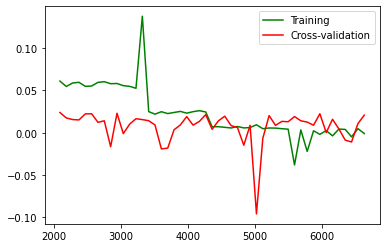

In [96]:
print("Estimating features number...", end='')
df_90 = df[df['public_transport_distance'] > 10].head(int(len(df) * 0.98))
X_train = df_90.drop(columns = "price_per_sq_meter")
y_train = df_90.price_per_sq_meter
pca = PCA()
scaler = StandardScaler()
m = len(X_train)
X_trans = scaler.fit_transform(X_train)
X_trans = pca.fit_transform(X_trans)
X_red = np.ndarray((m, 0))
total_variance = 0
index = 0
while total_variance < 0.99:
    X_red = np.append(X_red, X_trans[:, index].reshape(m, 1), axis = 1) 
    total_variance += pca.explained_variance_ratio_[index]
    index += 1
print("done! Taken {} features".format(index))

print("Building model...", end='')
model = make_pipeline(PolynomialFeatures(1), r.RANSACRegressor(base_estimator = r.Ridge()))
model.fit(X_red, y_train)
model.features = X_train.columns
model.features_num = index
print("done!")

print("Saving model...", end='')
joblib.dump(scaler, 'rent-model.scaler')
joblib.dump(pca, 'rent-model.pca')
joblib.dump(model, 'rent-model.pipeline')
print("done!")

In [ ]:
# print("Building learning curve...", end='')
# training_sizes, training_scores, validation_scores = learning_curve(
#     estimator = model,
#     X = X_red,
#     y = y_train,
#     train_sizes = np.linspace(2000, m * 0.8, dtype = int), 
#     cv = 5, 
#     n_jobs = -1
# )
# print("done!")

# line1, line2 = plt.plot(
#     training_sizes, training_scores.mean(axis = 1), 'g', 
#     training_sizes, validation_scores.mean(axis = 1), 'r')
# plt.legend((line1, line2), ('Training', 'Cross-validation'))